In [203]:
from model import *
import torch.nn.functional as F
import torch

cmap_channels = 18
paf_channels = 38
upsample_channels=256

resnet18 = torchvision.models.resnet34(pretrained=True)

device = torch.device('cuda')
model = torch.nn.Sequential(
    ResNetFeatureExtractor(resnet18),
    SelectInput(-1),
    Upsample(512, upsample_channels, 3),
    PoseHead(upsample_channels, cmap_channels, paf_channels)
)
model = model.to(device)

In [231]:
torch.save(model.state_dict(), 'model_noatt_r18_on.pt')

In [123]:
model.load_state_dict(torch.load('model_noatt_r18.pt'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [149]:
from coco_dataset import CocoPoseDataset, convert_coco_annotations

In [200]:
import torch
import torchvision.transforms
from coco_dataset import CocoPoseDataset, convert_coco_annotations

INPUT_SHAPE = (256, 256)

transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(INPUT_SHAPE),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
    
dataset = CocoPoseDataset(
    root='train2017',
    annotations='annotations/person_keypoints_train2017.json',
    shape=(INPUT_SHAPE[0] // 4, INPUT_SHAPE[1] // 4),
    stdev=1.5,
    transforms=transforms
)

test_dataset = CocoPoseDataset(
    root='val2017',
    annotations='annotations/person_keypoints_val2017.json',
    shape=(INPUT_SHAPE[0] // 4, INPUT_SHAPE[1] // 4),
    stdev=1.5,
    transforms=transforms
)

loading annotations into memory...
Done (t=6.55s)
creating index...
index created!
loading annotations into memory...
Done (t=0.18s)
creating index...
index created!


In [201]:
dataset.window = 20
test_dataset.window = 20

In [173]:
loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=16,
    shuffle=True,
    num_workers=0
)

In [204]:
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
NUM_EPOCHS = 50

model = model.train()
for i in range(NUM_EPOCHS):
    
    epoch_loss = 0.0
    j = 0
    for image, cmap, paf in iter(loader):
        optimizer.zero_grad()
        
        image = image.to(device)
        cmap = cmap.to(device)
        paf = paf.to(device)
        
        cmap_out, paf_out = model(image)
        
        cmap_mask = cmap.max(1, keepdim=True)[0]
        paf_mask = (paf[:, 0::2]**2 + paf[:, 1::2]**2).sqrt().max(1, keepdim=True)[0]
        
        cmap_loss = torch.mean((1e-3 + cmap_mask) * (cmap_out - cmap)**2)
        paf_loss = torch.mean((1e-3 + paf_mask) * (paf_out - paf)**2)
        
        loss = cmap_loss + paf_loss
        
        loss.backward()
        optimizer.step()
        
        if j % 50 == 0:
            print('%d, %d / %d: %f' % (i, j, len(loader), loss))
        
        j += 1
    
    print('%d, %f' % (i, epoch_loss / len(dataset)))

0, 0 / 4008: 0.003902


In [222]:
from topology import PARTS

In [169]:
PARTS.index('RELBOW')#[10]

3

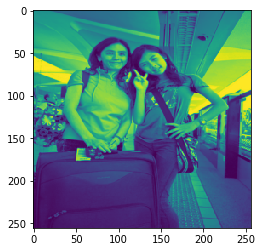

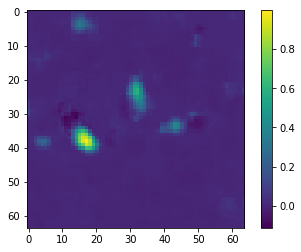

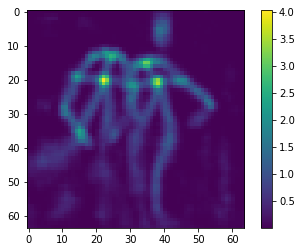

In [370]:
import matplotlib.pyplot as plt

image, cmap, paf = test_dataset[64]
image = image.to(device)[None, ...]
model = model.eval()
cmap_out, paf_out = model(image)

plt.imshow(image.cpu()[0][0][::1,::1])
plt.show()
plt.imshow(cmap_out.detach().cpu()[0][4], alpha=1.0)
plt.colorbar()
plt.show()
paf_out_mag = paf_out.detach().cpu()
paf_out_mag = (paf_out_mag[0][::2]**2 + paf_out_mag[0][1::2]**2).sum(0)
plt.imshow(paf_out_mag)
plt.colorbar()
plt.show()

In [371]:
cmap_out_cpu = cmap_out.cpu().detach()
paf_out_cpu = paf_out.cpu().detach()

In [375]:
import trt_pose.plugins

peak_counts, peaks = trt_pose.plugins.find_peaks(cmap_out_cpu, 0.8, 15, 100)
normalized_peaks = trt_pose.plugins.refine_peaks(peak_counts, peaks, cmap_out_cpu, 5)
score_graph = trt_pose.plugins.paf_score_graph(paf_out_cpu, dataset.topology, peak_counts, normalized_peaks, 10)
connections = trt_pose.plugins.assignment(score_graph, dataset.topology, peak_counts, 0.01)
object_counts, objects = trt_pose.plugins.connect_parts(connections, dataset.topology, peak_counts, 100)

In [376]:
object_counts

tensor([4], dtype=torch.int32)

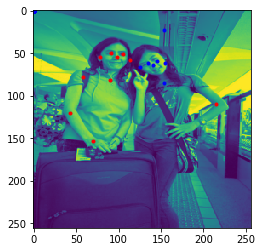

In [377]:
plt.imshow(image.cpu()[0][0])
for i in range(object_counts[0]):
    if i % 2 == 0:
        color = 'r.'
    else:
        color = 'b.'
    obj = objects[0][i]
    for j in range(len(obj)):
        idx = obj[j]
        peak = normalized_peaks[0][j][idx]
        x = peak[1] * 256.0
        y = peak[0] * 256.0
        plt.plot(x, y, color)
#         plt.text(x, y, '%d' % j)
plt.show()

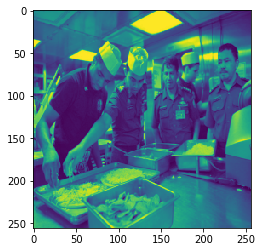

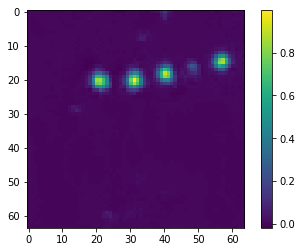

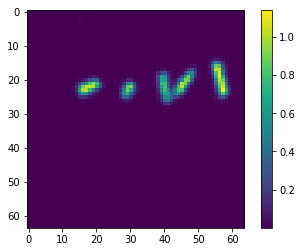

In [264]:
import matplotlib.pyplot as plt

image, cmap, paf = dataset[702]
image = image.to(device)[None, ...]
model = model.eval()
cmap_out, paf_out = model(image)

plt.imshow(image.cpu()[0][0])
plt.show()
plt.imshow(cmap_out.detach().cpu()[0][15], alpha=1.0)
plt.colorbar()
plt.show()
plt.imshow((paf_out.detach().cpu()[0][28:30]**2).sum(0))
plt.colorbar()
plt.show()